In [1]:
import pandas as pd
import numpy as np
import re

import numpy as np
import datetime as dt
from datetime import datetime   

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import squarify

%matplotlib inline

In [2]:
# Modelos
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [3]:
sns.set()
plt.rc('xtick', labelsize=10)     
plt.rc('ytick', labelsize=10)
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('clientes.csv', delimiter=';')
print(f"Tamaño del Dataset: {df.shape}")


Tamaño del Dataset: (4521, 17)


Importante aclarar que para la <font color='green'>reproducibilidad de los resultados</font> . Sobre todo para empresas de seguros que necesitan repetir el pricing para una cartera con un riesgo determinado, deben usar una semilla y debe ser la misma para dar los mismos resultados.

In [5]:
import random
random.seed(100)
random_state = 100

## Contexto

Una entidad bancaria acaba de realizar una campaña de marketing, cuyo objetivo buscaba lograr que los clientes contactados depositaran sus ahorros a plazo fijo. Los resultados fueron <font color='red'>peor</font>  de lo esperado.
Esta campaña se enfocó en un 10% de la cartera total de clientes del banco.

El banco contrata nuestros servicios como científic@ de datos y nos comunica los siguintes objetivos:

* Repetir una o más campañas en el transcurso de los siguientes 18 meses. 
* Maximizar la tasa de conversión de las mismas y entender los factores que influyen en esta tasa.


Nuestra tarea consiste en ayudar al banco a cumplir sus objetivos.

**Comentario Inicial**

El problema es de tipo comercial en donde una campaña asegura la conversión o no del cliente. Para esto también es importante determinar la cantidad de días que pasan para llegar a la conversión. Entendiendo entonces que existe un número óptimo de campañas dentro de los 18 meses (a ejemplo: si un cliente convierte a 90 días del contacto de la campaña, sólo podré hacer 6 campañas en 18 meses)

*Pasos a seguir*:

1. Preprocesamiento
2. Exploracion de la data e interpretacion
3. Regresion logistica
4. Arbol D3



\begin{equation*}
Target = {Realizó.plazo.fijo}
\end{equation*}

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


### Metadata

#### Datos clientes

El banco nos provee la lista de los ~4.5K clientes ("clientes.csv") que fueron contactados durante esta última campaña y nos informa que por el momento NO nos proveerá de mas datos que estos.

1. `age`: edad del clietne
2. `job`: tipo de trabajo
3. `marital`: estado civil
4. `education`: nivel de educación
5. `default`: indica si el cliente registra algún default crediticio
5. `balance`: saldo en dólares de la caja de ahorro del cliente
6. `housing`: indica si el cliente posee un préstamo hipotecario
7. `loan`: indica si el cliente posee algún préstamo personal

#### Datos del último contacto de la campaña actual
9. contact`: canal de contacto
10. `day`: día de último contacto
11. `month`: mes de último contacto
12. `duration`: duracion del último contacto
13. `campaign`: cantidad de contactos durante la campaña

#### Datos campaña previa
14. `pdays`: días transcurridos desde el último contacto por una campaña previa
15. `previous`: cantidad de contactos previous a esta campaña
16. `poutcome`: resultado de la campaña previa

#### Resultado campaña actual
17. `y` - Indica si el cliente realizó depósito a plazo fijo(binaria: 'yes','no')

In [7]:
df.head().T

,0,1,2,3,4
age,30,33,35,30,59
job,unemployed,services,management,management,blue-collar
marital,married,married,single,married,married
education,primary,secondary,tertiary,tertiary,secondary
default,no,no,no,no,no
balance,1787,4789,1350,1476,0
housing,no,yes,yes,yes,yes
loan,no,yes,no,yes,no
contact,cellular,cellular,cellular,unknown,unknown
day,19,11,16,3,5


In [8]:
df.previous.unique()

array([ 0,  4,  1,  3,  2,  5, 20,  7,  6, 10,  9,  8, 18, 19, 12, 13, 11,
       14, 15, 24, 17, 22, 23, 25], dtype=int64)

In [9]:
df.y.unique()

array(['no', 'yes'], dtype=object)

Observo las medidas de estadística descritptiva de las variables numericas. La edad promedio es de 41 años, el balance promedio de cliente es 1422, el día promedio de contacto es el día 155, la duración promedio del ultimo contacto es de 259, la cantidad de contactos promedio es de 2.79.

In [10]:
df.describe().round(2)

,age,balance,day,duration,campaign,pdays,previous
count,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00
mean,41.17,1422.66,15.92,263.96,2.79,39.77,0.54
std,10.58,3009.64,8.25,259.86,3.11,100.12,1.69
min,19.00,-3313.00,1.00,4.00,1.00,-1.00,0.00
25%,33.00,69.00,9.00,104.00,1.00,-1.00,0.00
50%,39.00,444.00,16.00,185.00,2.00,-1.00,0.00
75%,49.00,1480.00,21.00,329.00,3.00,-1.00,0.00
max,87.00,71188.00,31.00,3025.00,50.00,871.00,25.00


Será interesante estudiar cada variable por separado. Entendiendo las distrubciones a fin de entender que factores influyen en las campañas. 
* **Distribucion del target** `y`  determinar la conversión del cliente es nuestro target, por lo tanto complementarlo en el analisis de dato a las variables anteriores nos permitirá entender cómo se compone nuestra muestra.

* **Edad y rango etario** la edad es una variable importante a la hora de segmentar productos. Por lo tanto enfocaremos cómo punto de partida la distribución del target en función de  `age` .

* **Trabajo** El tipo de trabajo puede determinar la compra o no de productos financieros, en este caso entendemos al plazo fijo cómo un tipo de ahorro en un activo libre de riesgo.

* **Estacionalidad**: `days` y `month` los días de la semana y los meses determinaran la estacionalidad tal vez propia del producto (Si este caso fuese Argentina una hipotesis sería que los meses de aguinaldo la tasa de conversión podría ser mayor). 

* **Variables Económicas** `loan`, `balance`y `default`  seran también interesantes para segmentar. Será interesante hacer visualizaciones y analisis bivariados.

* Medios: `campaign` y  `contact`  Respecto al canal de campaña y las caracteristicas de contacto, establecer el comportamiento descriptivo de la data permite entender la operatividad de las llamadas y complementar luego a los modelos de predicción para elaborar una campaña con mayor probabilidad de conversión.

* Segmento target social: `marital`, `education`, no permitiran determinar la variables socioeconómicas de los clientes, sumado a las **data driven** de la campaña de marketing. 


### Heatmap: Correlaciones

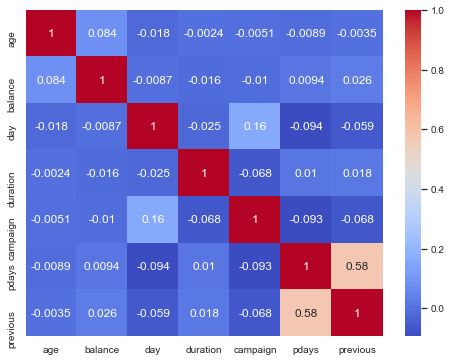

In [11]:
rcParams['figure.figsize'] = 8,6
sns.heatmap(df.corr(),cmap='coolwarm',annot=True)

Se observa una correlacion de 0.58 entre `pdays` y  `previous`, es decir que los días transcurridos entre el último contacto y la cantidad de contactos previos se relacionan positivamente. Ampliaremos esta relación, pero entendemos que en los posteriores modelos nos quedaremos sólo con una de la dos variables, tratando de evitar la multicolinealidad. Entendiendo que un modelo más simple para una cuestión interpretativa es mejor (*Occam's razor*)

## Preprocesamiento

### Missing Data
Chequeos si existen valores faltantes

In [12]:
#Porcentaje de nulos por variable en df
(df.isnull().sum().sort_values()/len(df))*100

age          0.0
previous     0.0
pdays        0.0
campaign     0.0
duration     0.0
month        0.0
day          0.0
poutcome     0.0
contact      0.0
housing      0.0
balance      0.0
default      0.0
education    0.0
marital      0.0
job          0.0
loan         0.0
y            0.0
dtype: float64

El dataset no posee faltantes. 

In [13]:
df.month = pd.to_datetime(df.month, format='%b').dt.month

Convierto la columna mes al tipo datetime

## Distribución del target

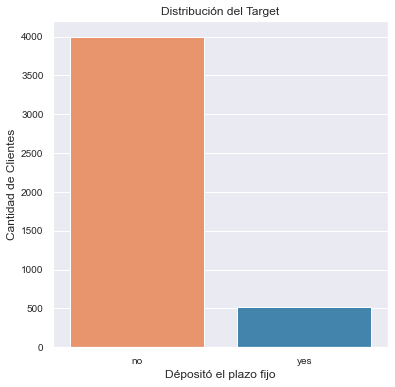

Porcentajes de plazo fijo en la muestra: 11.523999115239992
Porcentajes de NO plazo fijo en la muestra: 88.47600088476001


In [14]:
rcParams['figure.figsize'] = 6,6
paleta = ["#fc8d59","#3288bd"]

df['y'].value_counts()
sns.countplot(x='y', data=df, palette=paleta)
plt.xlabel("Dépositó el plazo fijo") 
plt.ylabel("Cantidad de Clientes")
plt.title("Distribución del Target")  
plt.show()



PF_NO = len(df[df['y']=='no'])
PF_YES = len(df[df['y']=='yes'])
no_plazofijo_porciento =( PF_NO / (PF_NO + PF_YES) * 100)
si_plazofijo_porciento= (PF_YES / (PF_NO + PF_YES) * 100)
print('Porcentajes de plazo fijo en la muestra:', si_plazofijo_porciento)
print('Porcentajes de NO plazo fijo en la muestra:', no_plazofijo_porciento)

Tenemos una distribución no equilibrada de las clases por lo cual tendremos que evaluar si realizamos algun método de sobresampleo o no en el futuro modelo.

Agrupo por target para ver la media según si hicieron el plazo fijo o no lo hicieron

In [15]:
df.groupby('y').mean()

,age,balance,day,month,duration,campaign,pdays,previous
y,,,,,,,,
no,40.998000,1403.211750,15.948750,6.146750,226.347500,2.862250,36.006000,0.471250
yes,42.491363,1571.955854,15.658349,6.320537,552.742802,2.266795,68.639155,1.090211


Se observa que los clientes que obtuvieron un plazo fijo tienen una edad media y un balance no es mucho mayor que los que no sacaron el plazo fijo. La diferencia en el valor de tendencia central se observa en la duración del ultimo contacto, la cual es mayor en los que convirtieron de los que no, y una cantidad mayor de días transcurridos desde el último contacto cómo también mayor cantidad de contactos previos.

Cómo primera intuición a validar con nuestros modelos observamos una relación positiva entre convertir (realizar el deposito) y las variables `duration`  y cantidad de contactos previos `previous`. Entendiendo que el promedio de los que convierten es 68 días entre llamada y llamada, cabe destacar que el promedio de  `pdays` días transcurridos es mayor en aquellos clientes que no convierten, teniendo que encontrar el punto óptimo entre cantidad de contactos en 180 días y el tiempo entre contacto.

In [16]:
df1 = df.copy()

In [17]:
# Paso a numerico el target para construir una correlacion pero viendo con que variable correlaciona
df1.y = df1.y.map({'no':0, 'yes':1}).astype('int32')

corr = df1.corr()
corr.style.background_gradient(cmap='PuBu')

,age,balance,day,month,duration,campaign,pdays,previous,y
age,1.000000,0.083820,-0.017853,0.073764,-0.002367,-0.005148,-0.008894,-0.003511,0.045092
balance,0.083820,1.000000,-0.008677,0.099872,-0.015950,-0.009976,0.009437,0.026196,0.017905
day,-0.017853,-0.008677,1.000000,0.080436,-0.024629,0.160706,-0.094352,-0.059114,-0.011244
month,0.073764,0.099872,0.080436,1.000000,-0.000282,0.059214,-0.112003,-0.037410,0.023335
duration,-0.002367,-0.015950,-0.024629,-0.000282,1.000000,-0.068382,0.010380,0.018080,0.401118
campaign,-0.005148,-0.009976,0.160706,0.059214,-0.068382,1.000000,-0.093137,-0.067833,-0.061147
pdays,-0.008894,0.009437,-0.094352,-0.112003,0.010380,-0.093137,1.000000,0.577562,0.104087
previous,-0.003511,0.026196,-0.059114,-0.037410,0.018080,-0.067833,0.577562,1.000000,0.116714
y,0.045092,0.017905,-0.011244,0.023335,0.401118,-0.061147,0.104087,0.116714,1.000000


In [18]:
del df1

#### Duration
Teniendo en cuenta la variable Y, en la matriz de correlacion observamos la variable `duration`  es la que más se correlaciona cón el target. Habrá que realizar el analisi con la variable duracion transformada y sin, para ver si esta correlacion nos imposibilitan la capacidad de generalizar del modelo.  Un posible approach sea generar bins respecto a la duración separandola en cuartiles. Ahora bien hay que tener en cuenta dos perspectivas de la variable `duration` , por un lado puede darnos perspectiva de cómo deben ser las caracteristicas de las llamadas, esta data se utiliza en Speech Analytics. Por otro lado, hay que entender que puede ser útil cómo variable historica, pero en un set de datos nuevos (clientes aún no llamados) existe la probabilidad que no tenga aún esta variable. Estudiaremos esto en la parte de Feature Selection.

In [19]:
paleta = ["#fc8d59","#3288bd"]
yes_df = df[df['y'] == 'yes']
no_df = df[df['y'] == 'no']

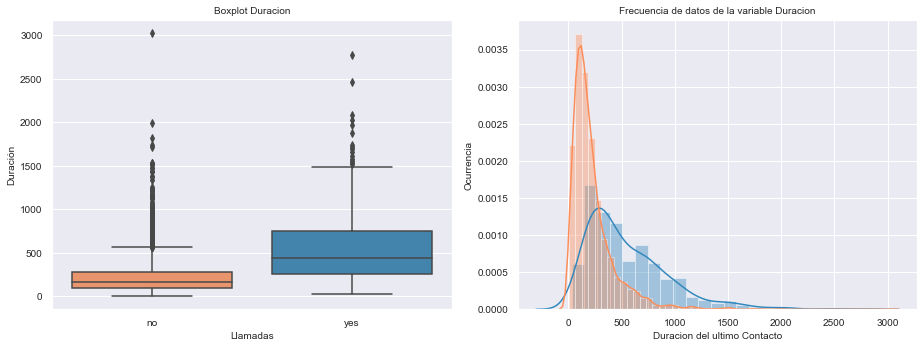

In [20]:
#Por la reproducibilidad de los graficos prefiero siempre GGPLOT a estos códigos de seaborn y matplot


fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))


sns.boxplot(y='duration', x='y', data=df, palette=paleta, ax = ax1)
ax1.set_xlabel('Llamadas', fontsize=10)
ax1.set_ylabel('Duración', fontsize=10)
ax1.set_title('Boxplot Duracion', fontsize=10)
ax1.tick_params(labelsize=10)


sns.distplot(yes_df['duration'],color='#3288bd', ax = ax2)
sns.distplot(no_df['duration'],color = '#fc8d59', ax = ax2) 
ax2.set_xlabel('Duracion del ultimo Contacto', fontsize=10)
ax2.set_ylabel('Ocurrencia', fontsize=10)
ax2.set_title('Frecuencia de datos de la variable Duracion', fontsize=10)
ax2.tick_params(labelsize=10)



plt.subplots_adjust(wspace=0.5)

plt.tight_layout() 

In [21]:
print('1º Cuartil: ', yes_df['duration'].quantile(q = 0.25))
print('2º Cuartil: ', yes_df['duration'].quantile(q = 0.50))
print('3º Cuartil: ', yes_df['duration'].quantile(q = 0.75))
print('4º Cuartil: ', yes_df['duration'].quantile(q = 1.00))   
print('La duración arriba de: ', yes_df['duration'].quantile(q = 0.75) + 
                      1.5*(yes_df['duration'].quantile(q = 0.75) - yes_df['duration'].quantile(q = 0.25)), 'son outliers para clientes que depositaron el plazo fijo')

1º Cuartil:  260.0
2º Cuartil:  442.0
3º Cuartil:  755.0
4º Cuartil:  2769.0
La duración arriba de:  1497.5 son outliers para clientes que depositaron el plazo fijo


In [22]:
print('1º Cuartil: ', no_df['duration'].quantile(q = 0.25))
print('2º Cuartil: ', no_df['duration'].quantile(q = 0.50))
print('3º Cuartil: ', no_df['duration'].quantile(q = 0.75))
print('4º Cuartil: ', no_df['duration'].quantile(q = 1.00))
print('La duración arriba de: ', no_df['duration'].quantile(q = 0.75) + 
                      1.5*(no_df['duration'].quantile(q = 0.75) - no_df['duration'].quantile(q = 0.25)), 'son outliers para los clientes que no depositaron el plazo fijo ')

1º Cuartil:  96.0
2º Cuartil:  167.0
3º Cuartil:  283.0
4º Cuartil:  3025.0
La duración arriba de:  563.5 son outliers para los clientes que no depositaron el plazo fijo 


## Edad y Rango etario

In [23]:
print('Edad Max: ', df['age'].max())
print('Mediana de la edad: ', df['age'].median())
print('Promedio de la edad: ', df['age'].mean())
print('Edad Min: ', df['age'].min())

Edad Max:  87
Mediana de la edad:  39.0
Promedio de la edad:  41.17009511170095
Edad Min:  19


Text(0.5, 1.0, 'Distribución de la edad en la muestra')

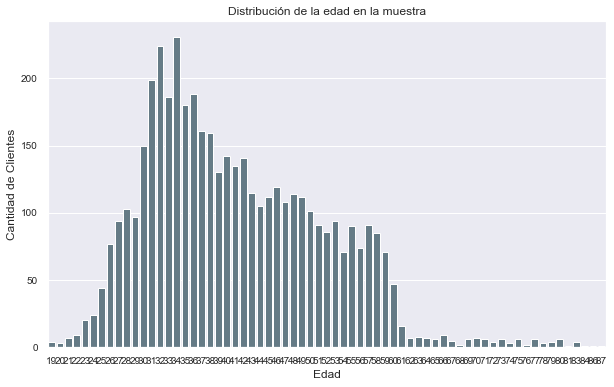

In [24]:
rcParams['figure.figsize'] = 10,6
sns.countplot(x = 'age', data = df,color = "#607d8b")
plt.xlabel("Edad") 
plt.ylabel("Cantidad de Clientes")
plt.title("Distribución de la edad en la muestra")  



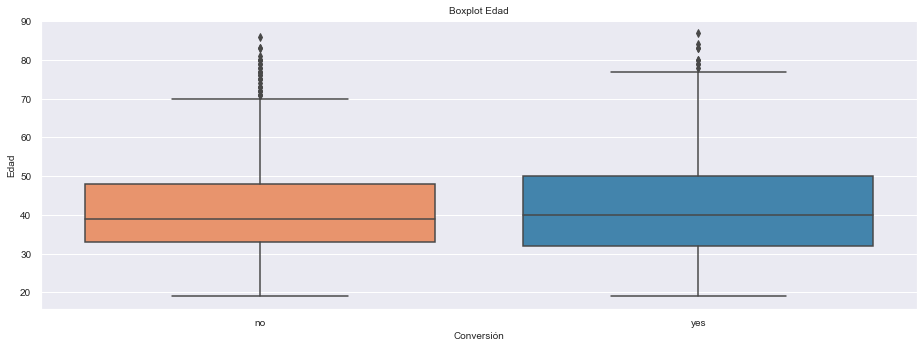

In [25]:
fig, (ax1) = plt.subplots( figsize = (13, 5))


sns.boxplot(y='age', x='y', data=df, palette=paleta, ax = ax1)
ax1.set_xlabel('Conversión', fontsize=10)
ax1.set_ylabel('Edad', fontsize=10)
ax1.set_title('Boxplot Edad', fontsize=10)
ax1.tick_params(labelsize=10)



plt.subplots_adjust(wspace=0.5)

plt.tight_layout() 

Observamos que el gráfico de edad tiene una asimetria hacia la izquierda.

¿Qué pasa si cruzamos edad con duración? ¿Donde se concentran la mayor cantidad de valores en toda la muestra separando entonces conversión de no conversión?

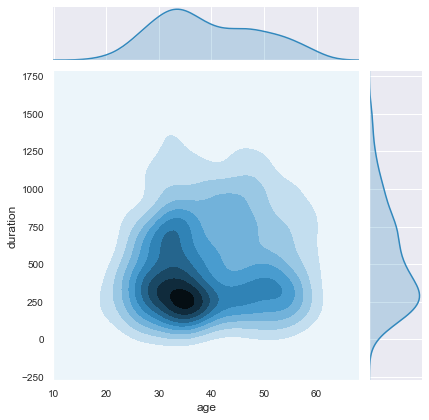

In [26]:
sns.jointplot(x='age', y='duration', data=yes_df[( yes_df['duration'] < 1497) & (yes_df['age'] < 60)], kind='kde', color='#3288bd')

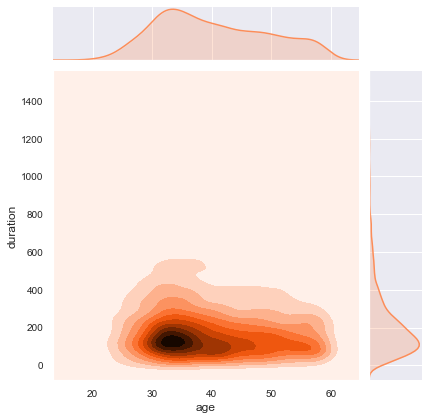

In [27]:
sns.jointplot(x='age', y='duration', data=no_df[(no_df['duration'] < 1497) & (no_df['age'] < 60)], kind='kde', color="#fc8d59")

Observamos que el centro de masa cambia en duración y no respecto a la edad.

In [28]:
del no_df
del yes_df

In [29]:
df["age"].describe()

count    4521.000000
mean       41.170095
std        10.576211
min        19.000000
25%        33.000000
50%        39.000000
75%        49.000000
max        87.000000
Name: age, dtype: float64

#### Agrupacion por rango etareo
Agrupo las edades por decadas

In [30]:
lst = [df]
for column in lst:
    column.loc[column["age"] < 30,  'grupo_edad'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), 'grupo_edad'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), 'grupo_edad'] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), 'grupo_edad'] = 50
    column.loc[column["age"] >= 60, 'grupo_edad'] = 60

In [31]:
total_por_edad = pd.crosstab(df['y'],df['grupo_edad'])
total_por_edad.loc['Total',:]= total_por_edad.sum(axis=0)
total_por_edad

grupo_edad,20.0,30.0,40.0,50.0,60.0
y,,,,,
no,408.0,1623.0,1080.0,770.0,119.0
yes,74.0,185.0,123.0,84.0,55.0
Total,482.0,1808.0,1203.0,854.0,174.0


In [32]:
crosstab_edad = pd.crosstab(df['y'],df['grupo_edad']).apply(lambda x: x/x.sum() * 100)
crosstab_edad = crosstab_edad.transpose() 

In [33]:
age = pd.DataFrame(df['grupo_edad'].value_counts())
age['% Decada'] = age['grupo_edad']*100/age['grupo_edad'].sum()
age['% Conversion'] = crosstab_edad['yes']
age.drop('grupo_edad',axis = 1,inplace = True)

age['age'] = [30,40,50,20,60]
age = age.sort_values('age',ascending = True)

In [34]:
age

,% Decada,% Conversion,age
20.0,10.661358,15.352697,20
30.0,39.991152,10.232301,30
40.0,26.609157,10.224439,40
50.0,18.889626,9.836066,50
60.0,3.848706,31.609195,60


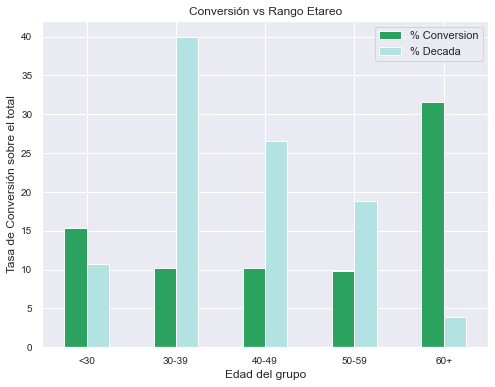

In [35]:
rcParams['figure.figsize'] = 8,6
sns.set_style("darkgrid")
plot_age = age[['% Conversion','% Decada']].plot(kind = 'bar',color = ('#2ca25f','#b2e2e2'))
plt.xlabel('Edad del grupo')
plt.ylabel('Tasa de Conversión sobre el total')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Conversión vs Rango Etareo')
plt.show()

In [36]:
del total_por_edad
del crosstab_edad
del age

Apuntar las llamadas a los extremos.

Cuando observamos la conversión por grupo etareo cambia la intuición al ver el total de las edades. Observamos que la conversión de los clientes mayores a 60 años es la más alta llegando a un 30% y a su vez aproximadamente un 15% de las conversiones son del extremo inferior, aquellos clientes con menos de 30 años.

Si dentro de la literatura financiera entendemos que un plazo fijo es un activo libre de riesgo (nunca en argentina), tendría sentido que los extremos etareos tengan aversión al riesgo, los jovenes porque pueden ahorrar para la educación y los mayores porque necesitan asegurar su retiro. 

Este grafico nos muestra que las llamadas del banco están orientadas al rango 30-40 y 40-49, con esta simple descripción de datos haría la primera recomendación de apuntar las llamadas a los extremos etareos. 

## Trabajos

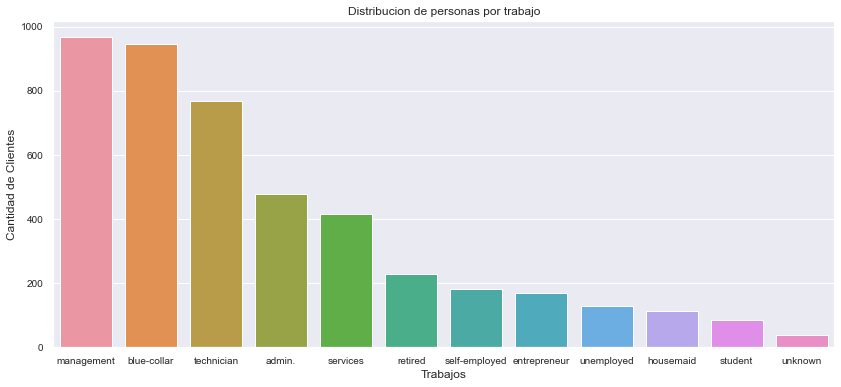

In [37]:
rcParams['figure.figsize'] = 14,6
trabajos = sns.countplot(x = 'job', data = df,
              order = df['job'].value_counts().index)
plt.xlabel("Trabajos")
plt.ylabel("Cantidad de Clientes")
plt.title("Distribucion de personas por trabajo") 
plt.show(trabajos)

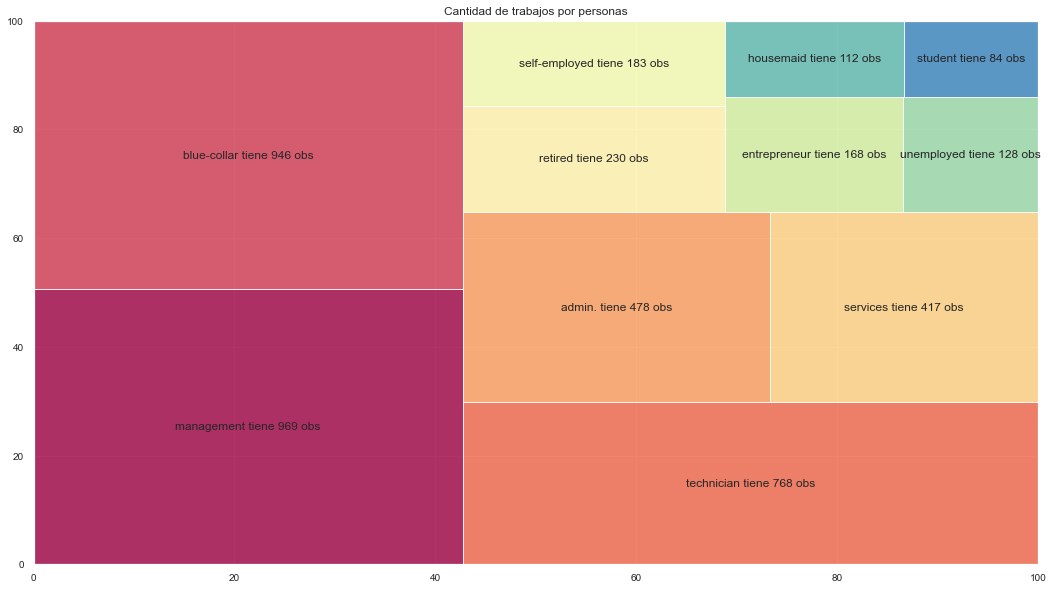

In [38]:
df1 = df.drop(df.loc[df["job"] == "unknown"].index) #Son solo 38 observaciones que para ver la distribucion del trabajo no me sirven
label_value = df1["job"].value_counts().to_dict()
# Creo los labels usando a list comprehesion
labels = ["{} tiene {} obs".format(class_, obs) for class_, obs in label_value.items()]
# Creo colores por cantidad de trabajos
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
plt.figure(figsize = (18, 10))
squarify.plot(sizes = label_value.values(), label = labels,  color = colors, alpha = 0.8)
plt.title("Cantidad de trabajos por personas");

In [39]:
cross_tab_trabajo = pd.crosstab(df['y'],df['job']).apply(lambda x: x/x.sum() * 100)
cross_tab_trabajo = cross_tab_trabajo.transpose()

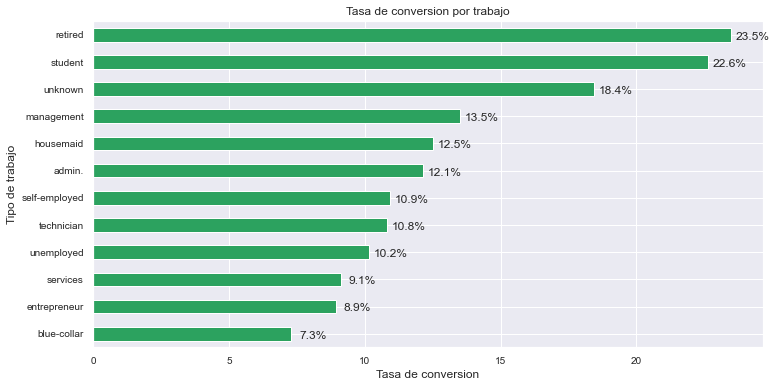

In [40]:
trabajo = cross_tab_trabajo['yes'].sort_values(ascending = True).plot(kind ='barh', color = "#2ca25f",
                                                                           figsize = (12,6))
                                                                               
plt.title('Tasa de conversion por trabajo')
plt.xlabel('Tasa de conversion')
plt.ylabel('Tipo de trabajo')

# Por estas funciones prefiero ggplot
for rec, label in zip(trabajo.patches,
                      cross_tab_trabajo['yes'].sort_values(ascending = True).round(1).astype(str)):
    trabajo.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

Consistentemente con la edad, las personas con mayor tasa de conversión son estudiantes o personas retiradas.

In [41]:
del cross_tab_trabajo
del trabajo

## Estacionalidad

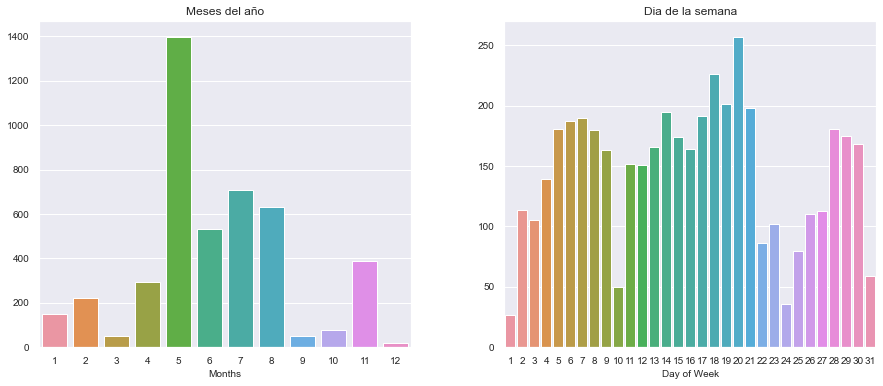

In [42]:
fig, (ax2, ax3) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))


sns.countplot(x='month', data=df, ax = ax2)
ax2.set_xlabel('Months', fontsize = 10)
ax2.set_ylabel('')
ax2.set_title('Meses del año')
ax2.tick_params()

sns.countplot(x='day', data=df, ax = ax3)
ax3.set_xlabel('Day of Week', fontsize = 10)
ax3.set_ylabel('')
ax3.set_title('Dia de la semana')
ax3.tick_params()

plt.subplots_adjust(wspace=0.25)

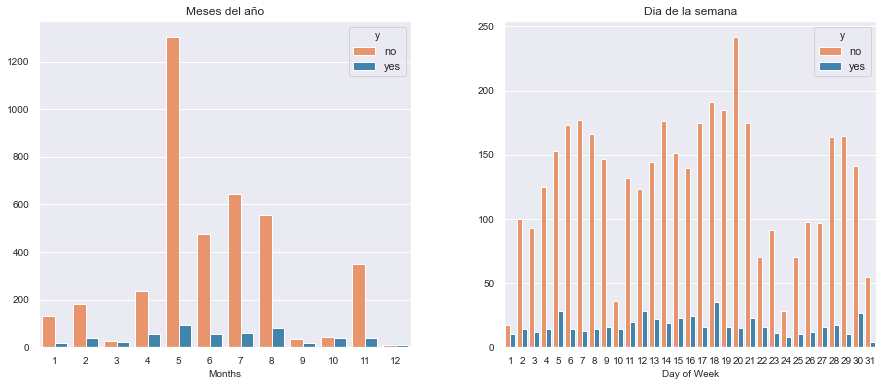

In [43]:
fig, (ax2, ax3) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))


sns.countplot(x="month", hue="y", palette=paleta, data=df, ax = ax2)
ax2.set_xlabel('Months', fontsize = 10)
ax2.set_ylabel('')
ax2.set_title('Meses del año')
ax2.tick_params()

sns.countplot(x='day', hue="y", palette=paleta, data=df, ax = ax3)
ax3.set_xlabel('Day of Week', fontsize = 10)
ax3.set_ylabel('')
ax3.set_title('Dia de la semana')
ax3.tick_params()

plt.subplots_adjust(wspace=0.25)

Aca grafiqué cantidad de llamadas con conversion y cantidad que no. Sería interesante graficar el % de conversión por mes y por día de la semana.

In [44]:
mes_totales= pd.crosstab(df['y'],df['month'])
mes_totales_t  = mes_totales.T
mes_totales_t["total"] = mes_totales.T.sum(axis=1)
mes_totales_t


y,no,yes,total
month,,,
1,132,16,148
2,184,38,222
3,28,21,49
4,237,56,293
5,1305,93,1398
6,476,55,531
7,645,61,706
8,554,79,633
9,35,17,52


In [45]:
crooss_tab_mes = pd.crosstab(df['y'],df['month']).apply(lambda x: x/x.sum() * 100)
crooss_tab_mes = crooss_tab_mes.transpose()

In [46]:
mes_cant = pd.DataFrame(df['month'].value_counts())
mes_cant['% Llamadas totales'] = mes_cant['month']*100/mes_cant['month'].sum()
mes_cant['% Conversion'] = crooss_tab_mes['yes']
mes_cant.drop('month',axis = 1,inplace = True)

#me quedó el mes cómo columna con el cross tab y desordenado
mes_cant['mes'] = [5,7,8,6,11,4,2,1,10,9,3,12]
mes_cant = mes_cant.sort_values('mes',ascending = True)
#mes_cant


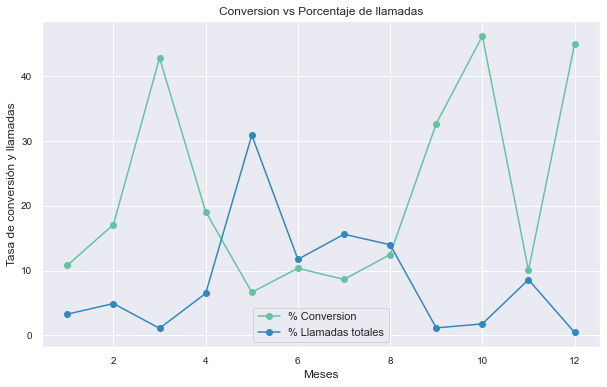

In [47]:
rcParams['figure.figsize'] = 10,6

plot_month = mes_cant[['% Conversion','% Llamadas totales']].plot(kind ='line',color = ('#66c2a4','#3288bd'),                                                          marker = 'o')

plt.title('Conversion vs Porcentaje de llamadas')
plt.ylabel('Tasa de conversión y llamadas')
plt.xlabel('Meses')

ticks = np.arange(1,13,1)
#plt.xticks(ticks)

plt.show()

In [48]:
mes_cant1 = mes_cant.copy()
mes_cant1.loc['Total',"% Llamadas totales"]=  mes_cant1["% Llamadas totales"].sum(axis=0)
mes_cant1

,% Llamadas totales,% Conversion,mes
1,3.273612,10.810811,1.0
2,4.910418,17.117117,2.0
3,1.083831,42.857143,3.0
4,6.480867,19.112628,4.0
5,30.922362,6.652361,5.0
6,11.745189,10.357815,6.0
7,15.616014,8.640227,7.0
8,14.001327,12.480253,8.0
9,1.150188,32.692308,9.0
10,1.769520,46.250000,10.0


In [49]:
print("La mayoría de las llamadas se realizaron en el mes de mayo, representando el %30  del total de llamadas")
mes_cant[mes_cant['% Llamadas totales'] == mes_cant['% Llamadas totales'].max()]



La mayoría de las llamadas se realizaron en el mes de mayo, representando el %30  del total de llamadas


,% Llamadas totales,% Conversion,mes
5,30.922362,6.652361,5


In [50]:
print("El maximo de % Conversion  se encuentra en el mes 10 con un % 46 de conversion de llamadas pero sólo un % 1,76 de llamadas totales")
mes_cant[mes_cant['% Conversion'] == mes_cant['% Conversion'].max()]

El maximo de % Conversion  se encuentra en el mes 10 con un % 46 de conversion de llamadas pero sólo un % 1,76 de llamadas totales


,% Llamadas totales,% Conversion,mes
10,1.76952,46.25,10


La recomendación sería hacer más campañas en el mes 10

In [51]:
#libero espacio del disco
del crooss_tab_mes
del mes_cant
del mes_cant1

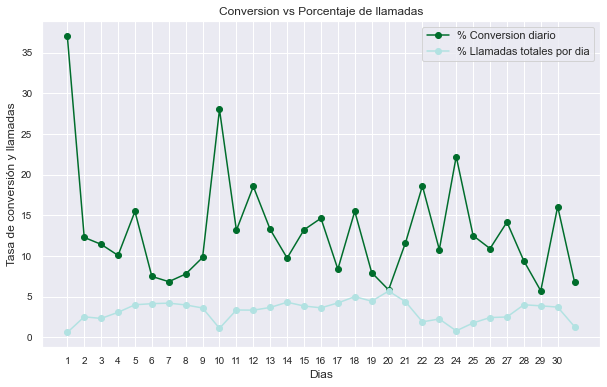

In [52]:
crooss_tab_dia = pd.crosstab(df['y'],df['day']).apply(lambda x: x/x.sum() * 100)
crooss_tab_dia = crooss_tab_dia.transpose()
dia_cant = pd.DataFrame(df['day'].value_counts())
dia_cant['% Llamadas totales por dia'] = dia_cant['day']*100/dia_cant['day'].sum()
dia_cant['% Conversion diario'] = crooss_tab_dia['yes']
dia_cant['dias'] = dia_cant.index


dia_cant = dia_cant.sort_values('dias',ascending = True)

rcParams['figure.figsize'] = 10,6

plot_dias = dia_cant[['% Conversion diario','% Llamadas totales por dia']].plot(kind ='line',color = ('#006d2c','#b2e2e2'),                                                          marker = 'o')

plt.title('Conversion vs Porcentaje de llamadas')
plt.ylabel('Tasa de conversión y llamadas')
plt.xlabel('Dias')

ticks = np.arange(1,31,1)
plt.xticks(ticks)

plt.show()


In [53]:
print("El maximo de llamadas totales se encuentra concentrado en el día 20 y el cual es uno de los días con menor conversión.")
dia_cant[dia_cant['% Llamadas totales por dia'] == dia_cant['% Llamadas totales por dia'].max()]

El maximo de llamadas totales se encuentra concentrado en el día 20 y el cual es uno de los días con menor conversión.


,day,% Llamadas totales por dia,% Conversion diario,dias
20,257,5.684583,5.836576,20


In [54]:
print("El maximo de % Conversion diario se encuentra en el 1er día del mes y el segundo pico se encuentra en el día 10. Podría tener sentido con los días en los que se cobra el sueldo")
dia_cant[dia_cant['% Conversion diario'] == dia_cant['% Conversion diario'].max()]

El maximo de % Conversion diario se encuentra en el 1er día del mes y el segundo pico se encuentra en el día 10. Podría tener sentido con los días en los que se cobra el sueldo


,day,% Llamadas totales por dia,% Conversion diario,dias
1,27,0.597213,37.037037,1


In [55]:
#libero espacio
del dia_cant
del crooss_tab_dia

## Variables economicas

In [56]:
# Colores = unique
color_labels = df['default'].unique()
rgb_values = sns.color_palette("Paired", 2)
#para usar la paleta paired por los labels 
color_map = dict(zip(color_labels, rgb_values))

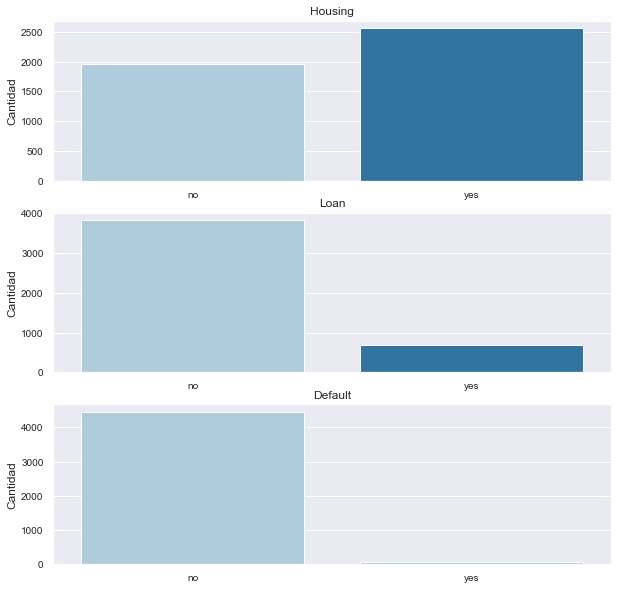

In [57]:

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10,10))
# Está en default?
sns.countplot(x = 'default', data = df, ax = ax3, order = ['no', 'yes'], palette=df['default'].map(color_map))
ax3.set_title('Default')
ax3.set_xlabel('')
ax3.set_ylabel('Cantidad')
ax3.tick_params()

# Tiene un prestamo hipotecario
sns.countplot(x = 'housing', data = df, ax = ax1, order = ['no',  'yes'], palette=df['housing'].map(color_map))
ax1.set_title('Housing')
ax1.set_xlabel('')
ax1.set_ylabel('Cantidad')
ax1.tick_params()

# Tiene un prestamo personal
sns.countplot(x = 'loan', data = df, ax = ax2, order = ['no', 'yes'], palette=df['loan'].map(color_map))
ax2.set_title('Loan')
ax2.set_xlabel('')
ax2.set_ylabel('Cantidad')
ax2.tick_params()

plt.subplots_adjust(wspace=0.8)

In [58]:
print('Default:\n No tiene creditos en default'     , df[df['default'] == 'no']     ['default'].count(),
              '\n Tienen creditos en default:' , df[df['default'] == 'yes']    ['default'].count())

Default:
 No tiene creditos en default 4445 
 Tienen creditos en default: 76


In [59]:
print('Housing:\n No tienen prestamos hipotecarios:'     , df[df['housing'] == 'no']     ['housing'].count(),
              '\n tTnen prestamos hipotecarios:' , df[df['housing'] == 'yes']    ['housing'].count())

Housing:
 No tienen prestamos hipotecarios: 1962 
 tTnen prestamos hipotecarios: 2559


In [60]:
print('Loan:\n No tienen prestamos personales:'     , df[df['loan'] == 'no']     ['loan'].count(),
              '\n Tienen prestamos personales:'    , df[df['loan'] == 'yes']    ['loan'].count())

Loan:
 No tienen prestamos personales: 3830 
 Tienen prestamos personales: 691


## Balance

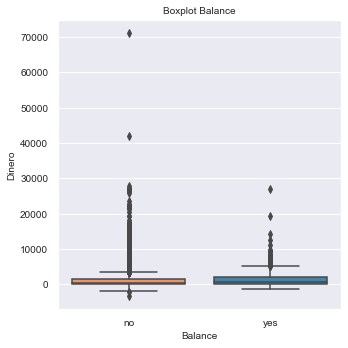

In [61]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
sns.boxplot(y='balance', x='y', data=df, palette=paleta, ax = ax1)
ax1.set_xlabel('Balance', fontsize=10)
ax1.set_ylabel('Dinero', fontsize=10)
ax1.set_title('Boxplot Balance', fontsize=10)
ax1.tick_params(labelsize=10)
plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 

In [62]:
print('1º Cuartil: ', df['balance'].quantile(q = 0.25))
print('2º Cuartil: ', df['balance'].quantile(q = 0.50))
print('3º Cuartil: ', df['balance'].quantile(q = 0.75))
print('4º Cuartil: ', df['balance'].quantile(q = 1.00))
print('La duración arriba de: ',df['balance'].quantile(q = 0.75) + 
                      1.5*(df['balance'].quantile(q = 0.75) - df['balance'].quantile(q = 0.25)), 'son outliers')

1º Cuartil:  69.0
2º Cuartil:  444.0
3º Cuartil:  1480.0
4º Cuartil:  71188.0
La duración arriba de:  3596.5 son outliers


No parece existir una política de llamadas. La dispersión del balance es muy grande. Sería interesante tener una idea para poder discretizar y separar entre clientes bajo, medio y alto. Pero cómo no sé en que tipo monetario está y no me puedo guiar por la distribución dejo este abordaje para posteriores estudios. 

### Estado civil y Educación

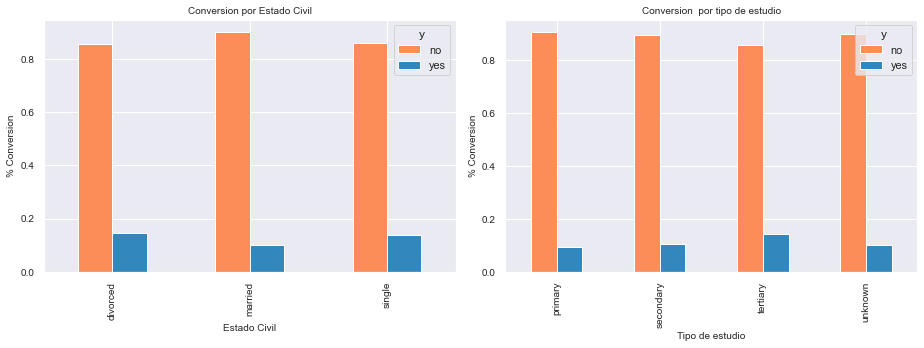

In [63]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
cross_tab_marital = pd.crosstab(df.marital, df.y)
cross_tab_marital.div(cross_tab_marital.sum(1).astype(float), axis=0).plot(kind='bar', stacked=False, color=['#fc8d59','#3288bd'], ax = ax1)
ax1.set_xlabel('Estado Civil', fontsize=10)
ax1.set_ylabel('% Conversion', fontsize=10)
ax1.set_title('Conversion por Estado Civil', fontsize=10)
ax1.tick_params(labelsize=10)


cross_tab_educacion = pd.crosstab(df.education, df.y)
cross_tab_educacion.div(cross_tab_educacion.sum(1).astype(float), axis=0).plot(kind='bar', stacked=False, color=['#fc8d59','#3288bd'], ax = ax2)

ax2.set_xlabel('Tipo de estudio', fontsize=10)
ax2.set_ylabel('% Conversion', fontsize=10)
ax2.set_title('Conversion  por tipo de estudio', fontsize=10)
ax2.tick_params(labelsize=10)


plt.subplots_adjust(wspace=0.5)

plt.tight_layout() 

In [64]:
#libero espacio del disco
del cross_tab_marital
del cross_tab_educacion

## Campaña y contacto

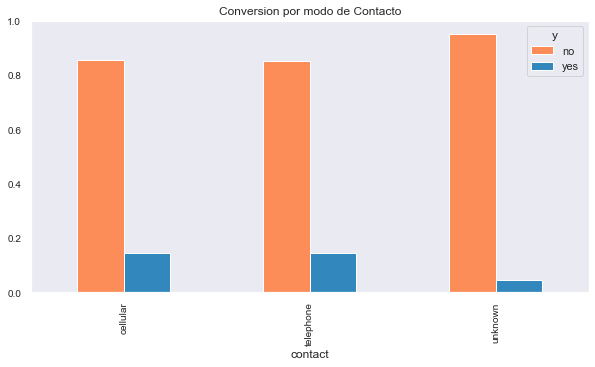

In [65]:
contacto = pd.crosstab(df.contact, df.y)
contacto.div(contacto.sum(1).astype(float), axis=0).plot(kind='bar', stacked=False, color=['#fc8d59','#3288bd'],grid=False, figsize=(10, 5))
plt.title("Conversion por modo de Contacto")
plt.show()

In [66]:
del contacto

In [67]:
df.campaign.unique()



array([ 1,  4,  2,  5,  3,  6, 18, 10,  9,  7, 12, 14, 13, 24, 11,  8, 29,
       32, 16, 22, 15, 30, 25, 21, 17, 19, 23, 20, 50, 28, 31, 44],
      dtype=int64)

In [68]:
len(df.campaign.unique())

32

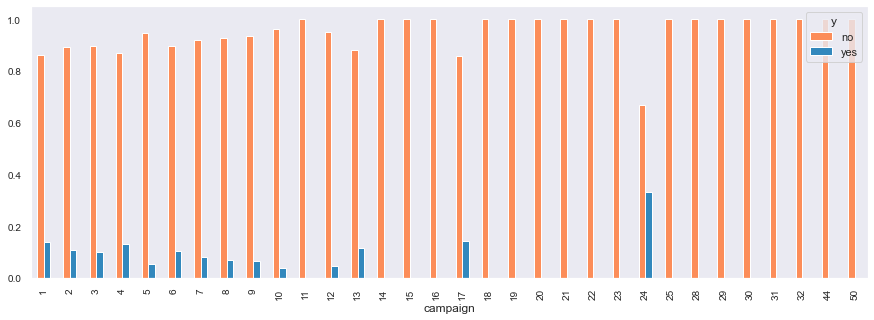

In [69]:
campaña = pd.crosstab(df.campaign, df.y)
campaña.div(campaña.sum(1).astype(float), axis=0).plot(kind='bar', stacked=False, color=['#fc8d59','#3288bd'],grid=False, figsize=(15, 5))
plt.show()

In [70]:
pd.crosstab(df['y'],df['campaign'])

campaign,1,2,3,4,5,6,7,8,9,10,...,23,24,25,28,29,30,31,32,44,50
y,,,,,,,,,,,,,,,,,,,,,
no,1494,1126,501,282,158,139,69,52,28,26,...,2,2,4,3,1,1,1,2,1,1
yes,240,138,57,43,9,16,6,4,2,1,...,0,1,0,0,0,0,0,0,0,0


In [71]:
crooss_tab_camp = pd.crosstab(df['y'],df['campaign']).apply(lambda x: x/x.sum() * 100) 
crooss_tab_camp = crooss_tab_camp.transpose()
camp = pd.DataFrame(df['campaign'].value_counts())
camp['% Llamadas totales'] = camp['campaign']*100/camp['campaign'].sum()
camp['% Conversion'] = crooss_tab_camp['yes']
camp1 = camp
camp1.loc['Total',"% Llamadas totales"]=  camp["% Llamadas totales"].sum(axis=0) #suma el total de la columna que da 100% 
camp1['campañas'] = camp1.index
camp1 = camp1.sort_values('% Conversion',ascending = False)
camp1[camp1['% Conversion']>1]

,campaign,% Llamadas totales,% Conversion,campañas
24,3.0,0.066357,33.333333,24
17,7.0,0.154833,14.285714,17
1,1734.0,38.354346,13.840830,1
4,325.0,7.188675,13.230769,4
13,17.0,0.376023,11.764706,13
2,1264.0,27.958416,10.917722,2
6,155.0,3.428445,10.322581,6
3,558.0,12.342402,10.215054,3
7,75.0,1.658925,8.000000,7
8,56.0,1.238664,7.142857,8


In [72]:
len(camp1[camp1['% Conversion']>1])

14

De las 32 campañas ejecutadas, sólo 14 superan el 1% de tasa de conversión. Recordemos que la tasa de conversión en este caso representa el ratio de clientes que realizaron el deposito sobre la cantidad que impacto esa campaña. Por ejemplo sólo se realizaron 3 llamadas de la campaña 24 y 1 de las llamadas fue una conversión. Habría que testear si esta tasa decae o se mantiene al aumentar la muestra.

En el caso de la campaña 1, representa el 38% de la muestra y tiene una tasa de conversión de 13%. Por lo cual podríamos establecerla cómo nuestra campaña estrella.

Cómo se muestra en el cuadro a continuación la campaña 11, 14, 15, 16, 18, 25, 19, 20, 28, 22, 32, 23,21,50,44,,29,30 y 31, deberían ser estudiadas para descartar, dado que latasa de conversión es menor al 1%

In [73]:
camp1[camp1['% Conversion']<1].sort_values('% Llamadas totales',ascending = False)

,campaign,% Llamadas totales,% Conversion,campañas
11,22.0,0.486618,0.0,11
14,10.0,0.221190,0.0,14
15,9.0,0.199071,0.0,15
16,8.0,0.176952,0.0,16
18,7.0,0.154833,0.0,18
25,4.0,0.088476,0.0,25
19,3.0,0.066357,0.0,19
20,3.0,0.066357,0.0,20
28,3.0,0.066357,0.0,28
22,2.0,0.044238,0.0,22


In [74]:
maximo = camp1[camp1['% Conversion']>1]
maximo['campañas'].unique()

array([24, 17, 1, 4, 13, 2, 6, 3, 7, 8, 9, 5, 12, 10], dtype=object)

In [75]:
import plotly.express as px

fig = px.scatter(maximo, x="% Llamadas totales", y="% Conversion", color="campañas",
                 size='% Llamadas totales', hover_data=['campañas'],
                title="Campañas en función de tasa de Conversion y tasa de llamadas")
fig.show()


In [76]:
del maximo
del campaña
del camp1
del camp

# Modelos

## Regresion Logistica

Recordemos que nuestro objetivo es:
* Repetir una o más campañas en el transcurso de los siguientes 18 meses.
* Maximizar la tasa de conversión de las mismas y entender los factores que influyen en esta tasa.

Por lo tanto nos interesa mantener todos las variables presentes, en caso de hacer un modelo de predicción de clientes deberíamos no elegir variables que no van a estar presentens en nuestra base de datos, cómo duration.

Ópte por un Regresión logística para tener interpretabilidad de los resultados, entendiendo a los coeficientes significativos cómo la probabilidad de ocurrencia.

### Selecion de variables por Random Forest

In [77]:
data = df.copy()

Transformé a objetos las variables día, mes y campaña que por defecto las tomaba cómo entero.

In [78]:
cat1 = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'day', 'month', 'campaign', 'poutcome',"grupo_edad"]

In [79]:
for var in cat1:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1

In [80]:
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat1]
data_final=data[to_keep]
data_final.columns.values

array(['age', 'balance', 'duration', 'pdays', 'previous', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16',
       'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22',
       'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28',
       'day_29', 'day_30', 'day_31', 'month_1', 'month_2', 'month_3',
       'month_

In [81]:
data_final['y'].unique()

array(['no', 'yes'], dtype=object)

In [82]:
from sklearn import preprocessing
# Función para encodear
def encoder(df, cat):
    le = preprocessing.LabelEncoder()
    clases = []
    for i in cat:
        df[i]=le.fit_transform(df[i]) 
        clases.append(le.classes_)
    return df, clases

In [83]:
data_final, target = encoder(data_final,"y")
target

[array(['no', 'yes'], dtype=object)]

In [119]:
data_final = data_final.drop(['age'],axis=1)

In [120]:
from sklearn.ensemble import ExtraTreesClassifier

In [121]:
X=data_final.drop(['y'],axis=1)
y=data_final.y

model = RandomForestClassifier()
model.fit(X,y)

RandomForestClassifier()

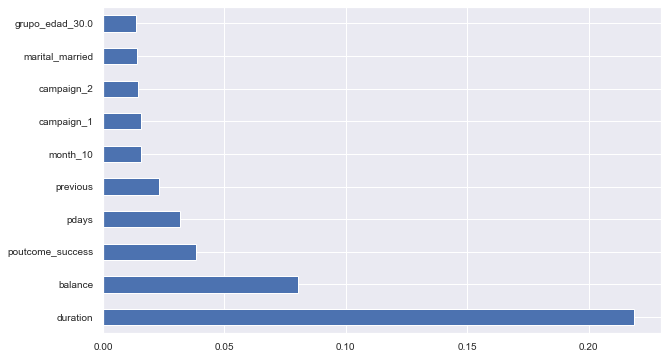

In [124]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [135]:
columnas = list(feat_importances.nlargest(10).index)

In [136]:
data_vars=data_final.columns.values.tolist()
to_keep=[i for i in data_vars if i in columnas]
x=data_final[to_keep]
x.columns.values

array(['balance', 'duration', 'pdays', 'previous', 'marital_married',
       'month_10', 'campaign_1', 'campaign_2', 'poutcome_success',
       'grupo_edad_30.0'], dtype=object)

### Smote: Oversampling
El algoritmo SMOTE funciona en 4 sencillos pasos:
Elija un vector de entrada de clase minoritaria
Encuentre sus k vecinos más cercanos (k_neighbors se especifica como un argumento en la función SMOTE ())
Elija uno de estos vecinos y coloque un punto sintético en cualquier lugar de la línea que une el punto en consideración y su vecino elegido
Repita los pasos hasta que los datos estén equilibrados

In [137]:
from imblearn.over_sampling import SMOTE

y = data_final.y

smote = SMOTE(random_state=100)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
columns = x_train.columns

smote_data_x,smote_data_y = smote.fit_sample(x_train, y_train)
smote_data_x = pd.DataFrame(data=smote_data_x, columns=columns)
smote_data_y = pd.DataFrame(data=smote_data_y, columns=['y'])



#### Balanceo de la clase

In [138]:
print('Tamaño de la data antes de hacer oversampling: ', len(x_train))
print('Data oversampleada: ', len(smote_data_y))
print('Clientes que no depositaron: ', len(smote_data_y[smote_data_y['y'] == 0]))
print('Clientes que depositaron: ', len(smote_data_y[smote_data_y['y'] == 1]))

Tamaño de la data antes de hacer oversampling:  3164
Data oversampleada:  5620
Clientes que no depositaron:  2810
Clientes que depositaron:  2810


In [139]:
import statsmodels.api as sm

In [140]:
training_x = smote_data_x
training_y = smote_data_y['y']

In [141]:
X_train_sm = sm.add_constant(training_x)
logm2 = sm.GLM(training_y,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 5620
Model:                            GLM   Df Residuals:                     5609
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2453.7
Date:                Tue, 18 Aug 2020   Deviance:                       4907.3
Time:                        18:06:13   Pearson chi2:                 1.41e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.4454      0.084     -5.308      0.000      -0.610      -0.281
balance           1.503e-05   1.22e-05      1.228      0.220   -8.96e-06     3.9e-05
duration             0.0051      0.000     28.612      0.000       0.005       0.005
pdays                0.0027      0.000      6.656      0.000       0.002       0.004
previous             0.0650      0.026      2.523      0.012       0.015       0.116
marital_married     -1.2160      0.072    -16.877      0.000      -1.357      -1.075
month_10             0.3934      0.314      1.254      0.210      -0.222       1.008
campaign_1          -0.8176      0.078    -10.425      0.000      -0.971      -0.664
campaign_2          -1.8250      0.108    -16.935      0.000      -2.036      -1.614
poutcome_success     2.2129      0.213     10.382      0.000       1.795       2.631
grupo_edad_30.0     -1.3407      0.083    -16.217      0.000      -1.503      -1.179
====================================================================================
"""

Coeficiente de balance es no representativo

\begin{align}
\dot{P(Deposito)} & = \beta_0+\beta_1 *balance+ \beta_2 *duration  + \beta_3 *pday+\beta_4 *previous
\beta_5 *maritalmarried+\beta_6 *month_10+\beta7 *campaign_1+\beta8 *campaign2+\beta9 *poutcomesucess +\beta910* grupo_edad_30
\end{align}

In [142]:
X_train, X_test, y_train, y_test = train_test_split(training_x, training_y,
                                                    test_size=0.3, random_state=100)

regressor = LogisticRegression()
regressor.fit(X_train, y_train)

LogisticRegression()

In [143]:
predictions = regressor.predict(X_test)
print('Accuracy on test set: ', regressor.score(X_test, y_test))

Accuracy on test set:  0.7882562277580071


In [144]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, predictions)

print('True Positive: ', confusion[0][0], 'False Negative: ', confusion[0][1])
print('False Positive: ', confusion[0][1], 'True Negative: ', confusion[1][1])

True Positive:  693 False Negative:  173
False Positive:  173 True Negative:  636


In [145]:
# Precision, recall, F-measure ve support
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

precision    recall  f1-score   support

           0       0.79      0.80      0.80       866
           1       0.79      0.78      0.78       820

    accuracy                           0.79      1686
   macro avg       0.79      0.79      0.79      1686
weighted avg       0.79      0.79      0.79      1686



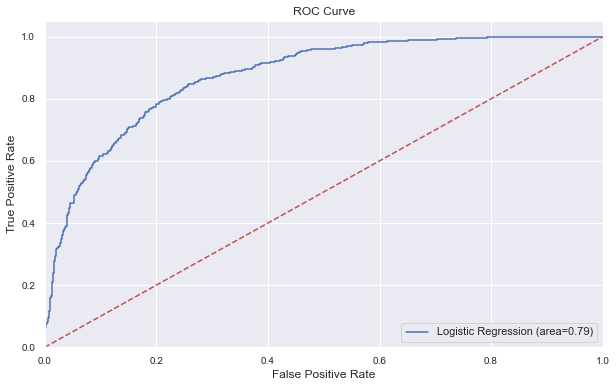

In [146]:
# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, predictions)
fpr, tpr, thresholds = roc_curve(y_test, regressor.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area=%0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('ROC-Curve')
plt.show()

La curva ROC es una herramienta común utilizada con clasificadores binarios. La línea de puntos representa un clasificador puramente aleatorio; un buen clasificador permanece lo más lejos posible de esa línea (hacia la esquina superior izquierda).

In [147]:
y_train_pred = res.predict(X_train_sm)

In [148]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.31955187, 0.1176297 , 0.12149111, 0.06976272, 0.05399035,
       0.3989535 , 0.18830752, 0.42058878, 0.17305321, 0.26356587])

In [149]:
y_train_pred_final = pd.DataFrame({'Converted':training_y.values, 'Converted_prob':y_train_pred})
y_train_pred_final['ID'] = training_y.index
y_train_pred_final.head()

,Converted,Converted_prob,ID
0,0,0.319552,0
1,0,0.117630,1
2,0,0.121491,2
3,0,0.069763,3
4,0,0.053990,4


In [150]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)
from sklearn import metrics
# Matriz de confusión 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )

In [151]:
# Busco puntos de corte
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_prob,ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.319552,0,0,1,1,1,1,0,0,0,0,0,0
1,0,0.117630,1,0,1,1,0,0,0,0,0,0,0,0
2,0,0.121491,2,0,1,1,0,0,0,0,0,0,0,0
3,0,0.069763,3,0,1,0,0,0,0,0,0,0,0,0
4,0,0.053990,4,0,1,0,0,0,0,0,0,0,0,0


In [152]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix



num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=cm1.sum()
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.631139  0.993594  0.268683
0.2   0.2  0.723310  0.960498  0.486121
0.3   0.3  0.771530  0.909609  0.633452
0.4   0.4  0.800178  0.856228  0.744128
0.5   0.5  0.804626  0.788256  0.820996
0.6   0.6  0.780961  0.688612  0.873310
0.7   0.7  0.767616  0.616014  0.919217
0.8   0.8  0.726690  0.503915  0.949466
0.9   0.9  0.651957  0.328114  0.975801


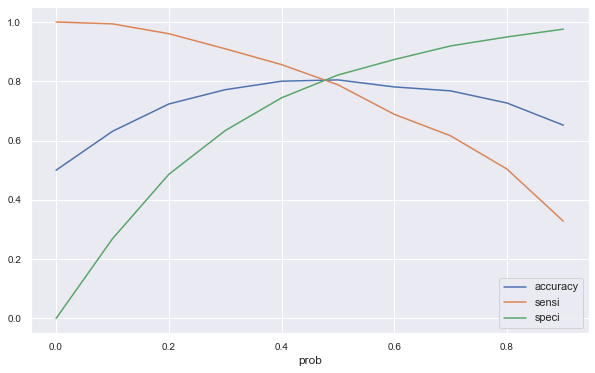

In [153]:
# El punto de corte se da en la interseccion de sensitivity  y specificity
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [154]:

y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_prob.map( lambda x: 1 if x > 0.48 else 0)

y_train_pred_final.head()

,Converted,Converted_prob,ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.319552,0,0,1,1,1,1,0,0,0,0,0,0,0
1,0,0.117630,1,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0.121491,2,0,1,1,0,0,0,0,0,0,0,0,0
3,0,0.069763,3,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.053990,4,0,1,0,0,0,0,0,0,0,0,0,0


In [155]:
y_train_pred_final['Lead_Score'] = y_train_pred_final.Converted_prob.map( lambda x: round(x*100))

#calculo la accuracy del modelo ahora
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [156]:
#sensitivity
Recall = TP / float(TP+FN)
print(f"Recall: {Recall.round(2)}")
#specificity
specificity = TN / float(TN+FP)
print(f"Specificity: {specificity.round(2)}")
# false postive rate 
fprt = FP/ float(TN+FP)
print(f"False postive rate : {fprt.round(2)}")
# Positive predictive value 
ppv = TP / float(TP+FP)
print(f"Precision: {ppv.round(2)}")


Recall: 0.8
Specificity: 0.81
False postive rate : 0.19
Precision: 0.81


In [157]:
#Matriz de confusión
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
confusion


array([[2307,  503],
       [ 595, 2215]], dtype=int64)

In [158]:
##### Chequeo Precision pero con la matriz de confusion
confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.8149374540103017

In [159]:
##### Chequeo el valor de Recall en matriz
confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.7882562277580071